# Convolutional Neural Network (CNN) to classify handwritten digits using the MNIST dataset

Dennis Riungu Muticia - 101174617

Matthias Otoo - 101145014

In [28]:
from ucimlrepo import fetch_ucirepo

import torch
from torch.utils.data import DataLoader, TensorDataset

from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE

from datetime import datetime

# Load the dataset

In [29]:
handwritten_digits = fetch_ucirepo(id=80)

X = handwritten_digits.data.features.to_numpy()
y = handwritten_digits.data.targets.to_numpy()

Visualise the first 5 data items

In [30]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,0,6,14,7,1,0,0
1,0,0,10,16,6,0,0,0,0,7,...,3,0,0,0,10,16,15,3,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,0,9,14,0,0,0,0
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,0,0,5,14,4,0,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0


Visualise 5 digits from the dataset

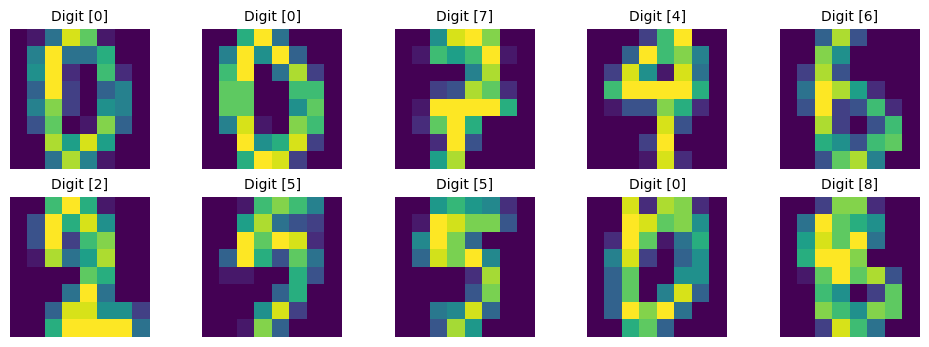

In [31]:
plt.figure(figsize=(12,4))
for index, (image, label) in enumerate(zip(X[0:10], y[0:10])):
    plt.subplot(2, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)))
    plt.title(f'Digit {label}', fontsize = 10)
    plt.axis('off')
plt.show()

## t-SNE analysis

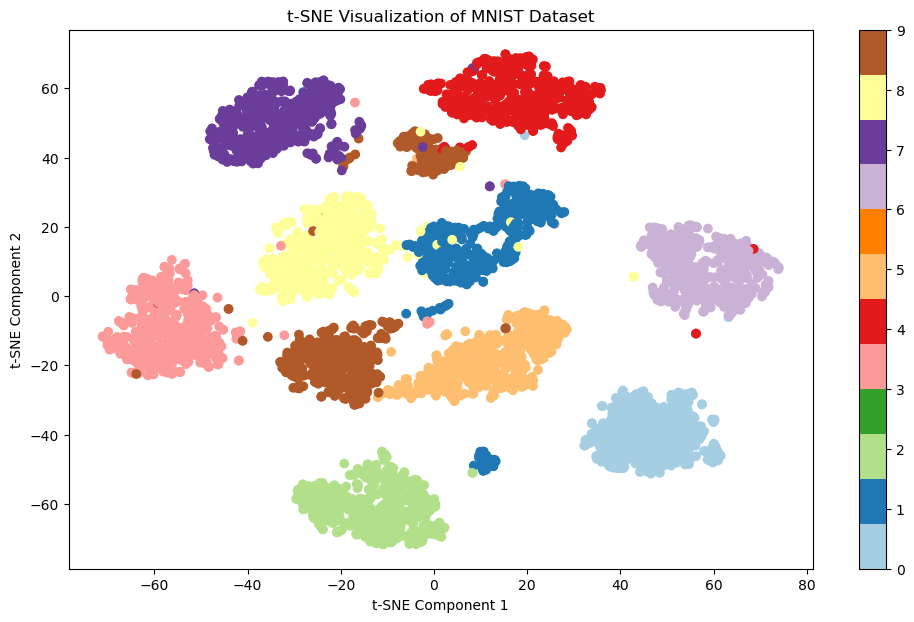

In [32]:
tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(X)

plt.figure(figsize=(12, 7))
plt.scatter(proj[:, 0], proj[:, 1], c=y, cmap="Paired")
plt.colorbar(ticks=range(10))
plt.title('t-SNE Visualization of MNIST Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Normalise and reshape the features

We will ***normalise*** the pixel values for each image to range between 0 and 1. We do this by dividing the pixel value by 255, the maximum possible pixel value.
This will help in:
- Faster training and convergence of the optimisation
- This will help the model learn with consistent data, capturing underlying patterns instead of being affected by by the scale of the input features

In [33]:
max_pixel = 16
X = X/max_pixel

Reshape data for CNN

In [34]:
dim_size = 8
batch_size = dim_size * dim_size
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

eval_metrics = {}

Prepare the train and test splits

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)

X_train = X_train.reshape(-1, 1, dim_size, dim_size)
X_test = X_test.reshape(-1,1, dim_size, dim_size)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [36]:
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': False} # CPU

train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), shuffle=True, **kwargs)
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), shuffle=False, **kwargs)

# Model architecture

Custom CNN Model

In [37]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = torch.nn.Sequential(
            # 1st Convolution layer
            torch.nn.Conv2d(1, 16, kernel_size=2, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),

            # 2nd Convolution layer
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),

            # 3rd Convolution layer
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),

            # 4th Convolution layer
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        # Fully connected
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output of the convolutional layers
        x = self.fc_layers(x) # Pass through the fully connected layers
        # x = x.view(-1, 1, 8, 8)  # Reshape to match the input size
        return x


# Model training

Training function

In [38]:
def train(model, n_epochs, device, train_loader, optimizer, criterion):
    for epoch in range(n_epochs):start = datetime.now()
    total_elapsed_time = 0.0

    training_accuracy = []
    training_loss = []
    accuracy = 0.0

    for epoch in range(n_epochs):
    
        model.train()
        running_loss = 0.0
        
        correct_predictions = 0

        for batchX, batchY in iter(train_loader):
            features = batchX.to(device)
            labels = batchY.to(device)

            optimizer.zero_grad()
            logits = model(features)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)

            _, predicted_labels = torch.max(logits, 1)
            _, labels = torch.max(labels, 1)
            correct_predictions += (predicted_labels == labels).sum().item()

        accuracy = correct_predictions / labels.shape[0]
        training_accuracy.append(accuracy)

        epoch_loss = running_loss / len(train_loader.dataset)
        training_loss.append(epoch_loss)

        end = datetime.now()
        epoch_elapsed_time = (end - start).total_seconds()
        total_elapsed_time += epoch_elapsed_time

        print( f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy}, Elapsed tme: {epoch_elapsed_time:.4f}")

    print(f"Total training time: {total_elapsed_time:.4f} seconds")
    print(f"Training Accuracy: {training_accuracy}")
    
    return training_loss, training_accuracy

Model training parameters

In [39]:
model = CNN().to(device)
learning_rate = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epochs = 5
losses = []

Run the training

In [40]:
traing_loss, train_accuracy = train(model, n_epochs, device, train_loader, optimizer, criterion)

eval_metrics['CustomCNN Training'] = {'Loss': traing_loss, 'Accuracy': train_accuracy}

Epoch [1/5], Loss: 2.2710, Accuracy: 14.042553191489361, Elapsed tme: 2.6764
Epoch [2/5], Loss: 2.0221, Accuracy: 40.42553191489362, Elapsed tme: 5.1361
Epoch [3/5], Loss: 1.8606, Accuracy: 55.319148936170215, Elapsed tme: 7.5535
Epoch [4/5], Loss: 1.7959, Accuracy: 61.12765957446808, Elapsed tme: 9.9426
Epoch [5/5], Loss: 1.7153, Accuracy: 68.68085106382979, Elapsed tme: 12.4021
Total training time: 37.7107 seconds
Training Accuracy: [14.042553191489361, 40.42553191489362, 55.319148936170215, 61.12765957446808, 68.68085106382979]


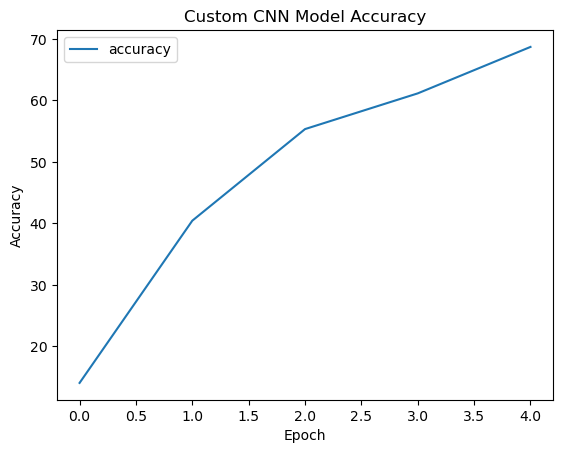

In [41]:
plt.plot(train_accuracy, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Custom CNN Model Accuracy')
plt.legend()
plt.show()

# Model evaluation

Evaluationn function

In [42]:
def evaluate(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            features = inputs.to(device)
            labels = labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}")

    return test_loss, 0.0


In [43]:
eval_loss, eval_accuracy = evaluate(model, device, test_loader, criterion)

eval_metrics['CustomCNN Eval'] = {'Loss': eval_loss, 'Accuracy': eval_accuracy}


Test Loss: 1.6782


Confusion matrix

In [44]:
# from sklearn.metrics import confusion_matrix

# def compute_confusion_matrix(model, data_loader):
#     model.eval()
#     all_labels = []
#     all_predictions = []

#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             all_labels.extend(labels.cpu().numpy())
#             all_predictions.extend(predicted.cpu().numpy())

#     cm = confusion_matrix(all_labels, all_predictions)
#     return cm


In [45]:
# confusion_matrix = compute_confusion_matrix(model, test_loader)
# print(confusion_matrix)

# Tensorflow and Keras Model for comparative analysis

Training and test sets

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)

X_train = X_train.reshape(-1, 8, 8, 1)
X_test = X_test.reshape(-1, 8, 8, 1)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

Keras CNN model

In [47]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(8, 8, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


/Users/mzitoh/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Compile the model

In [48]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train the model

In [49]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3345 - loss: 2.0458 - val_accuracy: 0.9206 - val_loss: 0.4853
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8958 - loss: 0.4037 - val_accuracy: 0.9509 - val_loss: 0.1650
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9300 - loss: 0.2363 - val_accuracy: 0.9556 - val_loss: 0.1535
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9431 - loss: 0.1800 - val_accuracy: 0.9860 - val_loss: 0.0659
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9771 - loss: 0.0924 - val_accuracy: 0.9790 - val_loss: 0.0727


Visualise training metrics

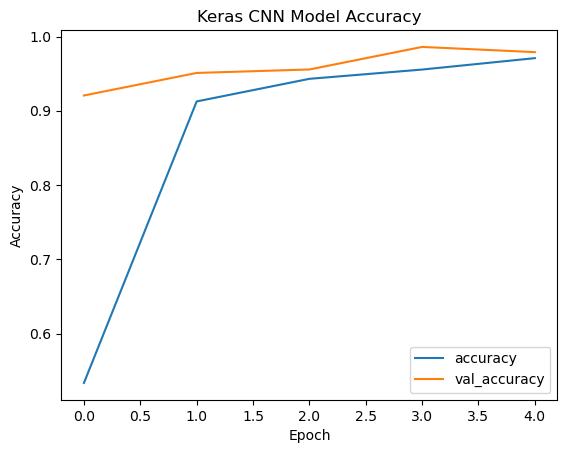

In [50]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Keras CNN Model Accuracy')
plt.legend()
plt.show()

Evaluate the model

In [51]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

eval_metrics['KerasCNN Eval'] = {'Loss': loss, 'Accuracy': accuracy}

 1/43 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 1.0000 - loss: 0.0388

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.1223
Test Loss: 0.1258, Test Accuracy: 0.9652
